# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## Updated 4/24/24

In [1]:
# Packages needed generally
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import numpy as np

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

In [2]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

### Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as 

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files. 

Things to note:
- The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".

In [3]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url= "s3://ncar-cesm-lens/ocn/static/grid.zarr"

The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables

In [4]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(component = "ocn").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,DIC,dissolved inorganic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DIC...
1,DOC,dissolved organic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DOC...
2,FW,freshwater flux,ocn,20C,monthly,1.0,global_ocean,centimeter/s,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-FW....
3,HMXL,mixed-layer depth,ocn,20C,monthly,1.0,global_ocean,centimeter,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-HMX...
4,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
...,...,...,...,...,...,...,...,...,...,...,...
123,WVEL,vertical velocity,ocn,RCP85,monthly,60.0,global_ocean,centimeter/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-W...
124,NaN,NaN,ocn,CTRL,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
125,NaN,NaN,ocn,HIST,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
126,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


In [5]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members = 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable= "SST",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

#col_grid = col.search(frequency="static", component="ocn", experiment=["20C", "RCP85"])
#col_grid.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
1,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


In [6]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)

# dgrid = col_grid.to_dataset_dict(
#     zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
# )

# print(f"\nDataset dictionary keys:\n {dsets.keys()}")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


In [7]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]
# #this was just checking to make sure these are correct 
# dg_20C = dgrid["ocn.20C.static"]
# dg_RCP85 = dgrid["ocn.RCP85.static"]

In [8]:
#this is mapping the whole world
ds_20C_mean=ds_20C.mean(dim="member_id")

test_2 = ds_20C_mean.SST.sel(time=slice("1920", "2000"))

test_1950_2 = test_2.sel(time='1950-03')
test_2000_2 = test_2.sel(time='2000-03')

#test_1950_2.squeeze().plot()


In [9]:
# #this is mapping the channel islands
# regbox=[240,330,220,260]
# #Then, open the xarray data you want; in the example below, I opened a file containing SST and called the xarray object "mytos". You can then generate "mask" arrays using logical statements; the arrays "mask_lon" and "mask_lat" below will be TRUE everywhere inside the region and FALSE everywhere else. The last line then uses the "where" statement to find all the data where the mask is TRUE, and drops everything else:

# # Read in specified region
# mask_lon = (test_1950_2.nlon >= regbox[2]) & (test_1950_2.nlon <= regbox[3])
# mask_lat = (test_1950_2.nlat >= regbox[0]) & (test_1950_2.nlat <= regbox[1])
# sst=test_1950_2.where(mask_lon & mask_lat, drop=True).squeeze()

#Lets make this plot nicer 
# fig = plt.figure(figsize=[10, 10])
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# #Lets move the map to focus on southern california 
# #lets make this smaller 
# ax.set_extent([230,250, 20, 40])
# test_1950_2.plot(ax=ax, cmap='coolwarm') #EDIT THE COLOR MAP HERE
# plt.title('Channel Islands SST in 1950')
# plt.show()

<Axes: >

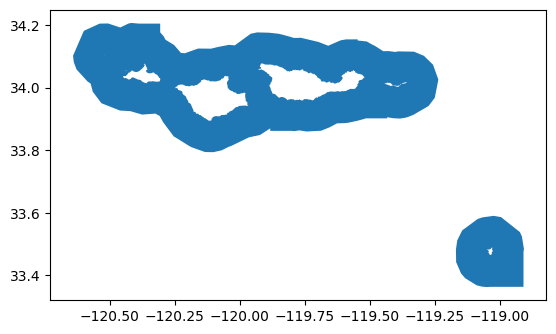

In [10]:
# path to channel island shapefile
cinms = 'cinms_py'

# Read the shapefile
pts = gpd.read_file(cinms)

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

In [11]:
#I want to plot sst on a plot with my cinms shape file 
#fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
#test_1950_2.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'SST (C)'})
#ax.set_extent([235, 245, 32, 36])
#ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
#ax.add_feature(cartopy.feature.OCEAN, zorder=0)
#ax.add_geometries(cinms_shape.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black')
#plt.show()



In [12]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

In [13]:
#subset tlat and tlong 
grid_sub = grid[['TLAT' , 'TLONG']]

grid_sub.load()

#merge the grid with the data
ds_20C_mean = ds_20C_mean.merge(grid_sub)

ds_20C_mean

test_5 = ds_20C_mean.SST.sel(time=slice("1920", "2000"))

test_1950_5 = test_5.sel(time='1950-03')

# test_1950_5.squeeze().plot()
test_1950_5


<xarray.DataArray 'SST' (time: 1, z_t: 1, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(1, 1, 384, 320), dtype=float32, chunksize=(1, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                (time) object 1950-03-16 12:00:00
  * z_t                 (z_t) float32 500.0
    TLAT                (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
    TLONG               (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
    ANGLE               (nlat, nlon) float64 0.0 0.0 0.0 ... -0.0259 2.804e-07
    ANGLET              (nlat, nlon) float64 0.0 0.0 0.0 ... -0.03805 -0.01268
    ...                  ...
    salt_to_ppt         float64 1e+03
    sea_ice_salinity    float64 4.0
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
Dimensions without coordinates: nlat, nlon

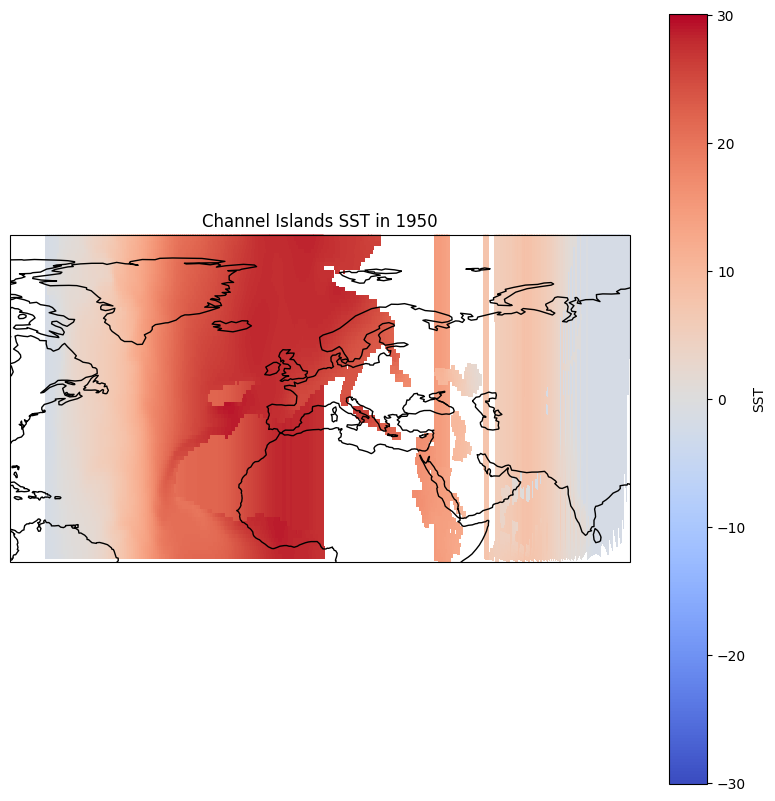

In [37]:
#lets plot the TLAT and TLONG instead of the nlat and lon
#Lets specify sst temperature
#this correctly prints it out 
#test_1950_5.plot(x = 'TLONG', y = 'TLAT', cmap='coolwarm')

#lets clean up that plot 
fig = plt.figure(figsize=[10, 10])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#Lets move the map to focus on southern california
#lets make this smaller
#ax.set_extent([230,250, 20, 40])
#Lets index TLAT and TLONG
test_1950_5.plot(x = "TLAT", y = "TLONG", cmap = "coolwarm") #EDIT THE COLOR MAP HERE
plt.title('Channel Islands SST in 1950')
plt.show()



THIS DOESN'T WORK (BELOW)

In [15]:
# #lets merge the grid data an ds_20C
# ds_20C = xr.merge([ds_20C, grid])  

# with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#   ds_20C = ds_20C.chunk({"time": 12})


In [16]:

#Understanding the grid data that merged with the CESM1 data 
print(ds_20C)

# #lets subset the data to our region of interest according to actual coordinates
# ds_20C = ds_20C.sel(nlat = slice(40,42), nlon = slice(118,124))

# ds_20C_mean=ds_20C.mean(dim="member_id")

# test_2 = ds_20C_mean.SST.sel(time=slice("1950", "2000"))

# test_1950_2 = test_2.sel(time='2000-03')

# #Lets check which dimensions were subsetted in ds_20C
# print(ds_20C.nlat)
# print(ds_20C.nlon)



<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 1, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 300, 1, 384, 320), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    NCO:                               4.4.4
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    ...          

In [17]:

# #using xesmf as a regridder but lets subset tlat and tlon from grid data first 
# grid_subset = grid[["TLAT", "TLONG"]]
# grid_subset

# #merge the grid_subset with ds_20C
# ds_20C = xr.merge([ds_20C, grid_subset])

In [18]:
# import numpy as np

# #create target grid
# target_grid = xr.Dataset(
#     {
#         "lat": (["lat"], np.arange(0, 91, 1)),
#         "lon": (["lon"], np.arange(0, 181, 1)),
#     }
# )

# #regridder
# regridder = xe.Regridder(ds_20C, target_grid, "bilinear")


### Example 2: CMIP6

Now I'll do the same thing for the multi-model CMIP6 database, following procedures similar to

https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/basic_search_and_load.ipynb

In [19]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [20]:
# Locate monthly sea surface temperature (tos) from all simulations of the historical period
df_ta = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'historical'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
995,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
996,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1023,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1030,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
9976,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
...,...,...,...,...,...,...,...,...,...,...,...
517087,CMIP,MIROC,MIROC-ES2L,historical,r26i1p1f2,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317
517088,CMIP,MIROC,MIROC-ES2L,historical,r26i1p1f2,Omon,tos,gr1,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317
517138,CMIP,MIROC,MIROC-ES2L,historical,r24i1p1f2,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317
517139,CMIP,MIROC,MIROC-ES2L,historical,r24i1p1f2,Omon,tos,gr1,gs://cmip6/CMIP6/CMIP/MIROC/MIROC-ES2L/histori...,NaN,20210317


In [21]:
# Get only information for a specific model: say, CanESM5
df_ta_canesm5 = df_ta.query('source_id == "CanESM5"')
df_ta_canesm5

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
79618,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
79938,CMIP,CCCma,CanESM5,historical,r10i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
80335,CMIP,CCCma,CanESM5,historical,r13i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
80639,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
80654,CMIP,CCCma,CanESM5,historical,r13i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
...,...,...,...,...,...,...,...,...,...,...,...
107480,CMIP,CCCma,CanESM5,historical,r16i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
107616,CMIP,CCCma,CanESM5,historical,r34i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
107630,CMIP,CCCma,CanESM5,historical,r31i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
107789,CMIP,CCCma,CanESM5,historical,r32i1p2f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


In [22]:
# create login credentials, for accessing file system anonymously: this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [23]:
# get all paths to the relevant datasets
zstore = df_ta_canesm5.zstore

# display them
zstore

79618     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
79938     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
80335     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
80639     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
80654     gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
                                ...                        
107480    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
107616    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
107630    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
107789    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
142449    gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
Name: zstore, Length: 65, dtype: object

In [24]:
# Test data I/O by using the first entry in the data table
zstore = df_ta_canesm5.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(215, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/56)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-his06
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 tos
    variant_label:               r6i1p2f1
    version:                     v20190429
    status:                      2019-11-11;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/81dad4e4-e025-4912-8e05-ea48266...
    version_id:                  v20190429

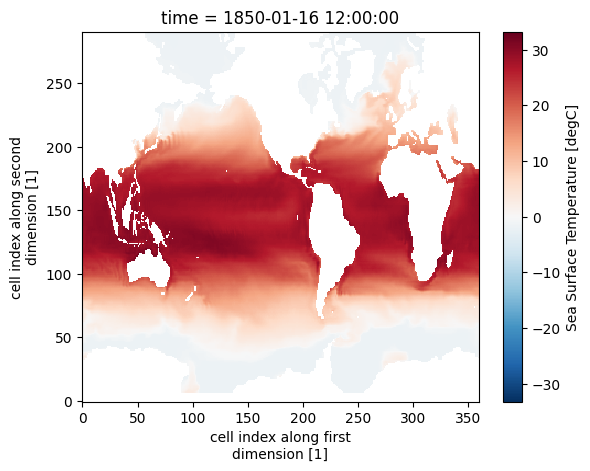

In [33]:
#lets plot by referring to i and j 
ds.tos.isel(time=0).plot()



In [26]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(30, 20), 
#                        subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the Xarray dataset as background
# ds_20C_mean['TEMP'].plot(ax=ax, 
#          transform=ccrs.PlateCarree())

# # Set the extent of the plot based on the shapefile bounding box
# ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# # Plot the shapefile
# #cinms_shape.plot(ax=ax, facecolor = "none")

# # Add gridlines
# ax.gridlines(draw_labels=True)

# # Add a title
# ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# # Show the plot
# plt.show()

In [27]:
# Merge the datasets
#merged_dataset = xr.merge([grid] + list(dsets.values()))

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming ds.tos has dimensions (time, lat, lon)
tos_at_specific_time = ds.tos.sel(time='1900-03')

# # Set up the plot
# fig = plt.figure(figsize=[10, 5])
# ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.set_extent([235, 245, 32, 36])
# #add cinms
# ax.add_geometries(cinms_shape.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black')
# # Plot the data
# tos_at_specific_time.plot(ax=ax)
# plt.title('Mean Sea Surface Temperature (March 2010)')
# plt.show()
